# Differentiable Convex Optimization Layers: JAX Tutorial

In [1]:
import cvxpy as cp
import numpy as np

import jax
import jax.numpy as jnp
from cvxpylayers.jax import CvxpyLayer

import matplotlib.pyplot as plt
plt.style.use('bmh')

np.set_printoptions(precision=2, suppress=True)

This notebook introduces the [JAX](https://github.com/google/jax)
library accompanying our
[NeurIPS paper](https://web.stanford.edu/~boyd/papers/pdf/diff_cvxpy.pdf)
on differentiable convex optimization layers with [CVXPY](https://www.cvxpy.org/).
A convex optimization layer solves a parametrized convex optimization problem
in the forward pass to produce a solution.
It computes the derivative of the solution with respect to the
parameters in the backward pass.
For more details, see our main repository at
[cvxgrp/cvxpylayers](https://github.com/cvxgrp/cvxpylayers)
and our
[blog post](https://locuslab.github.io/2019-10-28-cvxpylayers/).

## Parametrized convex optimization
Express problems of the form
$$
\begin{array}{ll} \mbox{minimize} & f_0(x;\theta)\\
\mbox{subject to} & f_i(x;\theta) \leq 0, \quad i=1, \ldots, m\\
& A(\theta)x=b(\theta),
\end{array}
$$
with variable $x \in \mathbf{R}^n$ and parameters $\theta\in\Theta\subseteq\mathbf{R}^p$

* objective and inequality constraints $f_0, \ldots, f_m$ are *convex* in $x$ for each $\theta$, *i.e.*, their graphs curve upward
* equality constraints are linear
* for a given value of $\theta$, find a value for $x$ that minimizes objective, while satisfying constraints
* we can efficiently solve these globally with near-total reliability

## Solution map
* Solution $x^\star$ is an implicit function of $\theta$
* When unique, define solution map as function
$x^\star = \mathcal S(\theta)$
* Need to call numerical solver to evaluate
* This function is often differentiable
* We show how to analytically differentiate this function, using the implicit function theorem
* Benefits of analytical differentiation: works with nonsmooth objective/constraints, low memory usage, don't compound errors

## CVXPY
* High level domain-specific language (DSL) for convex optimization
* Define variables, parameters, objective, and constraints
* Synthesize into problem object, then call solve method
* We've added derivatives to CVXPY (forward and backward)
* More information available [here](https://www.cvxpy.org/)

## CVXPYlayers
![](https://github.com/cvxgrp/cvxpylayers/blob/master/cvxpylayers_logo.png?raw=true)
* Convert CVXPY problems into callable, differentiable Pytorch and Tensorflow modules in one line

## Applications of differentiable convex optimization
* [learning convex optimization models (structured prediction)](https://stanford.edu/~boyd/papers/learning_copt_models.html)
* learning decision-making policies (reinforcement learning)
  * [differentiable model-predictive control](https://arxiv.org/abs/1810.13400)
  * [convex optimization control policies](https://stanford.edu/~boyd/papers/learning_cocps.html)
* [machine learning hyper-parameter tuning and feature engineering](https://stanford.edu/~boyd/papers/lsat.html)
* [repairing infeasible or unbounded optimization problems](https://stanford.edu/~boyd/papers/auto_repair_cvx.html)
* [as protection layers in neural networks](http://physbam.stanford.edu/~fedkiw/papers/stanford2019-10.pdf)
* [learning constraints and rules](https://arxiv.org/abs/1703.00443)
* [custom neural network layers (sparsemax, csoftmax, csparsemax, LML)]( https://locuslab.github.io/2019-10-28-cvxpylayers/)
* [meta-learning through differentiable solvers](https://arxiv.org/abs/1904.03758)
* [and many more... ](https://github.com/bamos/thesis)

# ReLU, sigmoid, and softmax examples

This example follows the setup in
[our blog post](https://locuslab.github.io/2019-10-28-cvxpylayers/)
and shows how to implement standard activation functions
as differentiable convex optimization layers.
These are presented as an exercise to illustrate the
representational and modeling power of differentiable convex
optimization, and for these examples, provides no implementation
benefit over the original forms of these layers.

## The ReLU

As shown in [Section 2.4 here](https://github.com/bamos/thesis).
we can interpret the ReLU as projecting
a point $x\in\mathbb{R}^n$ onto the non-negative orthant as

$$
  \hat y = {\rm argmin}_y \;\; \frac{1}{2}||y-x||_2^2 \;\; {\rm s.t.} \;\; y\geq 0.
$$

The usual explicit solution can be obtained by taking the
first-order optimality conditions.

Using `cvxpylayers`, we are able to easily implement
this optimization problem as a JAX layer.
This is powerful since it does not require that
our optimization problem has an explicit closed-form
solution (even though the ReLU does) and this
also shows how easy we can now take this optimization
problem and tweak it if we wanted to do so, without
having to re-derive the appropriate solution and
backwards pass.
Since this is computing the same function as the ReLU,
we would expect that the derivative looks the same.
This is indeed true and we have made it so our optimization layer
can be differentiated through just like any other JAX layer
using automatic differentiation.

Text(0, 0.5, '$\\nabla f(x)$')

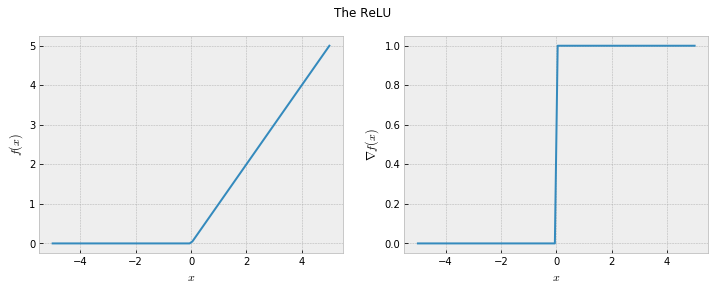

In [2]:
# Implement the problem as usual with CVXPY:
n = 100
_x = cp.Parameter(n)
_y = cp.Variable(n)
obj = cp.Minimize(cp.sum_squares(_y-_x))
cons = [_y >= 0]
prob = cp.Problem(obj, cons)

# Create the JAX layer
relu_layer = CvxpyLayer(prob, parameters=[_x], variables=[_y])

# Differentiate through the JAX layer
def relu_layer_sum(x):
    return jnp.sum(relu_layer(x)[0])

drelu_layer = jax.grad(relu_layer_sum)

nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
fig.suptitle('The ReLU')

x = jnp.linspace(-5, 5, num=n)

ax = axs[0]
ax.plot(x, relu_layer(x)[0])
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

ax = axs[1]
ax.plot(x, drelu_layer(x))
ax.set_xlabel('$x$')
ax.set_ylabel(r'$\nabla f(x)$')

## The sigmoid

Similarly, **the sigmoid or logistic** activation
function $f(x) = (1+e^{-x})^{-1}$ can be
seen from a convex optimization perspective as discussed in
[Section 2.4 here](https://github.com/bamos/thesis).
The sigmoid
projects a point $x\in\mathbb{R}^n$ onto
the interior of the unit hypercube as

$$
  f(x) = {\rm argmin}_{0\lt y\lt 1} \; -x^\top y -H_b(y),
$$

where $H_b(y) = - \left(\sum_i y_i\log y_i + (1-y_i)\log (1-y_i)\right)$ is the
binary entropy function.
This can be proved by looking at the KKT conditions.

Text(0, 0.5, '$\\nabla f(x)$')

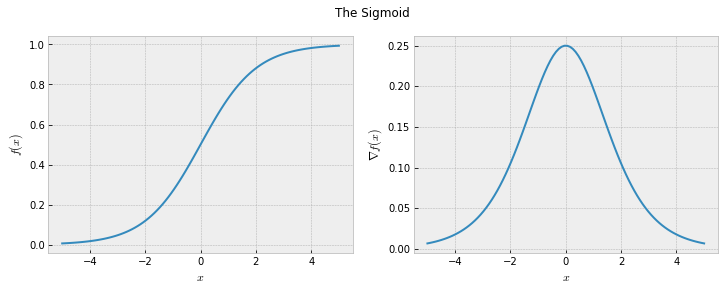

In [3]:
n = 100

_x = cp.Parameter(n)
_y = cp.Variable(n)
obj = cp.Minimize(-_x.T@ _y - cp.sum(cp.entr(_y) + cp.entr(1.-_y)))
prob = cp.Problem(obj)

layer = CvxpyLayer(prob, parameters=[_x], variables=[_y])

# Differentiate through the JAX layer
def layer_sum(x):
    return jnp.sum(layer(x)[0])

dlayer = jax.grad(layer_sum)

nrow, ncol = 1, 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
fig.suptitle('The Sigmoid')

x = jnp.linspace(-5, 5, num=n)

ax = axs[0]
ax.plot(x, layer(x)[0])
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

ax = axs[1]
ax.plot(x, dlayer(x))
ax.set_xlabel('$x$')
ax.set_ylabel(r'$\nabla f(x)$')

## The softmax
Lastly the **softmax** activation function
$f(x)\_j = e^{x\_j} / \sum\_i e^{x\_i}$ can
be implemented in JAX as follows.
This time we'll consider a single vector
instead of range of values since the softmax is
only interesting in higher dimensions.


We can again interpret the softmax as projecting a point
$x\in\mathbb{R}^n$ onto
the interior of the $(n-1)$-simplex
$$\Delta_{n-1}=\{p\in\mathbb{R}^n\; \vert\; 1^\top p = 1 \; \; {\rm and} \;\; p \geq 0 \}$$
as

$$
  f(x) = {\rm argmin}_{0\lt y\lt 1} \;\; -x^\top y - H(y) \;\; {\rm s.t.}\;\; 1^\top y = 1
$$

where $H(y) = -\sum\_i y\_i \log y\_i$ is the entropy function.
This is also proved in [Section 2.4 here](https://github.com/bamos/thesis)
by using the KKT conditions.
We can implement the variational form of the softmax with:

In [4]:
d = 5
_x = cp.Parameter(d)
_y = cp.Variable(d)
obj = cp.Minimize(-_x.T @ _y - cp.sum(cp.entr(_y)))
cons = [np.ones(d).T @ _y == 1.]
prob = cp.Problem(obj, cons)
layer = CvxpyLayer(prob, parameters=[_x], variables=[_y])

key = jax.random.PRNGKey(0)
key, k1 = jax.random.split(key, 2)
x = jax.random.normal(k1, shape=(d,))
y, = layer(x)

dsoftmax = jax.grad(lambda x: jax.nn.softmax(x)[0])
dlayer = jax.grad(lambda x: layer(x)[0][0])

print('=== Softmax forward pass')
print('jax.nn.softmax: ', jax.nn.softmax(x))
print('Convex optimization layer: ', layer(x)[0])

print('\n=== Softmax backward pass')
print('jax.nn.softmax: ', dsoftmax(x))
print('Convex optimization layer: ', dlayer(x))

=== Softmax forward pass
jax.nn.softmax:  [0.02 0.01 0.66 0.27 0.03]
Convex optimization layer:  [0.02 0.01 0.66 0.27 0.03]

=== Softmax backward pass
jax.nn.softmax:  [ 0.02 -0.   -0.01 -0.01 -0.  ]
Convex optimization layer:  [ 0.02 -0.   -0.01 -0.01 -0.  ]


## Elastic-net regression example 
This example has a similar setup to Section 6.1
of [our NeurIPS paper](https://arxiv.org/abs/1910.12430).
We are given training data $(x_i, y_i)_{i=1}^{N}$,
where $x_i\in\mathbf{R}$ are inputs and $y_i\in\mathbf{R}$ are outputs.
Suppose we fit a model for this regression problem by solving the elastic-net problem
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \frac{1}{N}\sum_{i=1}^N (ax_i + b - y_i)^2 + \lambda |a| + \alpha a^2,
\end{array}
\label{eq:trainlinear}
\end{equation}
where $\lambda,\alpha>0$ are hyper-parameters.

We hope that the test loss $\mathcal{L}^{\mathrm{test}}(a,b) =
\frac{1}{M}\sum_{i=1}^M (a\tilde x_i + b - \tilde y_i)^2$ is small, where
$(\tilde x_i, \tilde y_i)_{i=1}^{M}$ is our test set.

First, we set up our problem, where $\{x_i, y_i\}_{i=1}^N$, $\lambda$, and $\alpha$ are our parameters.

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

np.random.seed(0)
n = 2
N = 60
X, y = make_blobs(N, n, centers=np.array([[2, 2], [-2, -2]]), cluster_std=3)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.5)

Xtrain, Xtest, ytrain, ytest = map(
    jnp.array, [Xtrain, Xtest, ytrain, ytest])
m = Xtrain.shape[0]

a = cp.Variable((n, 1))
b = cp.Variable((1, 1))
X = cp.Parameter((m, n))
Y = ytrain[:, np.newaxis]

log_likelihood = (1. / m) * cp.sum(
    cp.multiply(Y, X @ a + b) - cp.logistic(X @ a + b)
)
regularization = - 0.1 * cp.norm(a, 1) - 0.1 * cp.sum_squares(a)
prob = cp.Problem(cp.Maximize(log_likelihood + regularization))
fit_logreg = CvxpyLayer(prob, [X], [a, b])

np.random.seed(0)
n = 1
N = 60
X = np.random.randn(N, n)
theta = np.random.randn(n)
y = X @ theta + .5 * np.random.randn(N)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.5)
Xtrain, Xtest, ytrain, ytest = map(
    jnp.array, [Xtrain, Xtest, ytrain, ytest])

m = Xtrain.shape[0]

# set up variables and parameters
a = cp.Variable(n)
b = cp.Variable()
X = cp.Parameter((m, n))
Y = cp.Parameter(m)
lam = cp.Parameter(nonneg=True)
alpha = cp.Parameter(nonneg=True)

# set up objective
loss = (1/m)*cp.sum(cp.square(X @ a + b - Y))
reg = lam * cp.norm1(a) + alpha * cp.sum_squares(a)
objective = loss + reg

# set up constraints
constraints = []

prob = cp.Problem(cp.Minimize(objective), constraints)

In [6]:
# convert into pytorch layer in one line
fit_lr = CvxpyLayer(prob, [X, Y, lam, alpha], [a, b])
# this object is now callable with JAX arrays
fit_lr(Xtrain, ytrain, jnp.zeros(1), jnp.zeros(1))

(DeviceArray([[-0.66]], dtype=float32), DeviceArray([0.14], dtype=float32))

In [7]:
# sweep over values of alpha, holding lambda=0, evaluating the gradient along the way
alphas = jnp.logspace(-3, 2, 200)
test_losses = []
grads = []

def loss(alpha):
    a_tch, b_tch = fit_lr(Xtrain, ytrain, jnp.zeros(1), alpha)
    test_loss = jnp.mean((Xtest @ a_tch.flatten() + b_tch - ytest)**2)
    return test_loss

# derivative of the loss with respect to alpha
loss_grad = jax.grad(loss)

for alpha in alphas:
    test_losses.append(loss(alpha))
    grads.append(loss_grad(alpha))

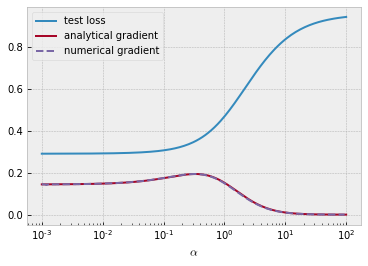

In [8]:
plt.semilogx()
plt.plot(alphas, test_losses, label='test loss')
plt.plot(alphas, grads, label='analytical gradient')
plt.plot(alphas[:-1], np.diff(test_losses) / np.diff(alphas), label='numerical gradient', linestyle='--')
plt.legend()
plt.xlabel("$\\alpha$")
plt.show()

In [9]:
# sweep over values of lambda, holding alpha=0, evaluating the gradient along the way
lams = jnp.logspace(-3, 2, 200)
test_losses = []
grads = []

def loss(lam):
    a_tch, b_tch = fit_lr(Xtrain, ytrain, lam, jnp.zeros(1))
    test_loss = jnp.mean((Xtest @ a_tch.flatten() + b_tch - ytest)**2)
    return test_loss

# derivative of the loss with respect to lambda
loss_grad = jax.grad(loss)

for lam in lams:
    test_losses.append(loss(lam))
    grads.append(loss_grad(lam))

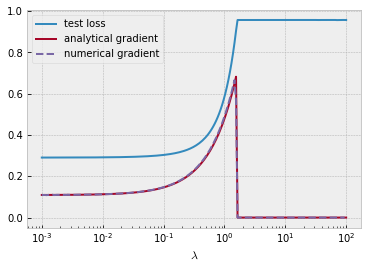

In [10]:
plt.semilogx()
plt.plot(lams, test_losses, label='test loss')
plt.plot(lams, grads, label='analytical gradient')
plt.plot(lams[:-1], np.diff(test_losses) / np.diff(lams), label='numerical gradient', linestyle='--')
plt.legend()
plt.xlabel("$\\lambda$")
plt.show()

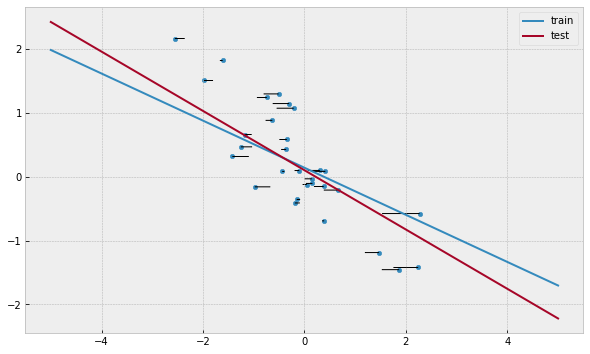

In [11]:
# compute the gradient of the test loss wrt all the training data points, and plot
plt.figure(figsize=(10, 6))

def loss(X):
    a_tch, b_tch = fit_lr(
        X, ytrain, jnp.array([.05]), jnp.array([.05]), solver_args={"eps": 1e-8})
    test_loss = jnp.mean((Xtest @ a_tch.flatten() + b_tch - ytest)**2)
    return test_loss, a_tch, b_tch

# derivative of the loss with respect to lambda
loss_grad = jax.grad(lambda X: loss(X)[0], argnums=0)

test_loss, a_tch, b_tch = loss(Xtrain)
Xtrain_grad = loss_grad(Xtrain)

a_tch_test, b_tch_test = fit_lr(
    Xtest, ytest, jnp.array([0.]), jnp.array([0.]), solver_args={"eps": 1e-8})
plt.scatter(Xtrain, ytrain, s=20)
plt.plot([-5, 5], [-3*a_tch.item() + b_tch.item(),3*a_tch.item() + b_tch.item()], label='train')
plt.plot([-5, 5], [-3*a_tch_test.item() + b_tch_test.item(), 3*a_tch_test.item() + b_tch_test.item()], label='test')

for i in range(Xtrain.shape[0]):
    plt.arrow(Xtrain[i].item(), ytrain[i],
              -30.*Xtrain_grad[i][0], 0., color='k')
plt.legend()
plt.show()

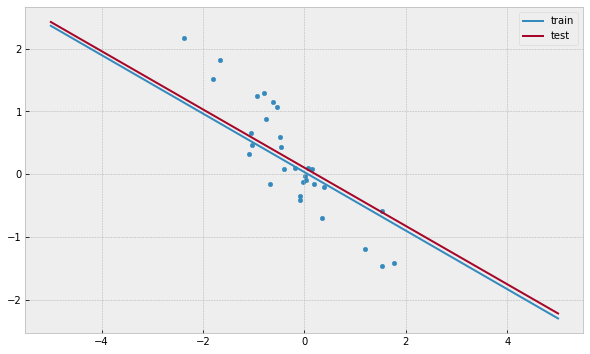

In [12]:
# move the training data points in the direction of their gradients, and see the train line get closer to the test line
plt.figure(figsize=(10, 6))
Xtrain_new = Xtrain - 30. * Xtrain_grad
a_tch, b_tch = fit_lr(
    Xtrain_new, ytrain, jnp.array([.05]), jnp.array([.05]), solver_args={"eps": 1e-8})
plt.scatter(Xtrain_new, ytrain, s=20)
plt.plot([-5, 5], [-3*a_tch.item() + b_tch.item(),3*a_tch.item() + b_tch.item()], label='train')
plt.plot([-5, 5], [-3*a_tch_test.item() + b_tch_test.item(), 3*a_tch_test.item() + b_tch_test.item()], label='test')
plt.legend()
plt.show()